<a href="https://colab.research.google.com/github/MinghanChu/DeepLearning-ZerosToGans/blob/main/Training%20deep%20NN%20on%20GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Objectives of image classification**

1. Using MNIST dataset in PyTorch to work with images
2. Splitting a dataset into **training, validation, and test** sets
3. Extending `nn.Module` class to create my own PyTorch models
4. Interpreting model outputs as probabilities using Softmax and picking predicted labels
5. Picking a useful evaluation metric (accuracy) and loss function (cross-entropy) for classification problems
6. Using the **validation set** to to evaluate my model by setting up a **training loop**
7. Using the test set to manually test my model on randomly picked examples
8. saving and loading model checkpoints to avoid retraining from scratch  

# **Using GPU for training**
+ training on GPU can be a lot faster than that on CPU, e.g., minutes vs hours!!

+ we have to first enable the GPU option from "Runtime"

+ **using training and validation datasets for obtaining a good model, i.e., high accuracy and low loss**, but we do not test our model using the training and validation datasets!

+ after training our model, we test our model using **test datasets**

## **Using MNIST dataset in PyTorch to work with images**

## Preparing the Data

Recall that linear-regression logistic regression model is used to identify handwritten digits from the MNIST dataset with an accuracy of around 86%. The dataset consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We noticed that it's quite challenging to improve the accuracy of a logistic regression model beyond 87%, since the model assumes a **linear relationship** between **pixel intensities and image labels**.

In this post, we'll try to improve upon it  using a **feed-forward neural network** which can capture non-linear relationships between inputs and targets.

Let's begin by installing and importing the required modules and classes from `torch`, `torchvision`, `numpy`, and `matplotlib`.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`.

when working with the MNIST dataset, you typically have two main components for each data sample: the image itself (usually represented as a matrix or a flattened vector) and its corresponding label (an integer). This allows you to train machine learning models to recognize handwritten digits based on the provided images and their associated labels.

**For each image in the MNIST dataset, there is an associated label indicating the digit it represents. These labels are integers ranging from 0 to 9, inclusive, corresponding to the digits from zero to nine.**

+ `transform=ToTensor()`: images are downloaded as pytorch tensor shape: `1x28x28`(color channel, width, height)

+ `plt.imshow` is used to display the images. This object requirs **the color channel to be the last dimension in an image tensor**. so use `permute` method to reorder the dimensions of the images

+ `root='data/'`: datasets are downloaded to the specified root

+ PyTorch doesn't know how to work with images! We need to convert the images into **tensors** using the `torchvision.transforms` module, containing many useful predefined functions.


In [4]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 19865092.29it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 592341.89it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1421116.11it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4098650.77it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



+ `image, label = dataset[0]` means the first image of the dataset: `image` contains $28 \times 28$ pixels

+ we check the original image shape, i.e., `image.shape` and gets `[1, 28, 28]`

+ `image.permute()` can be used to reorder the dimensions, e.g., `image.permute(1,2,0)` that puts the first dimension as the last dimension

+ Note that image is a 3D array. image[0] means slicing the color channel, not the width or height for pixels. Why? Because Python defaults the first index to the channel dimension. Since this is a grayscale image, only one index is available, i.e., 0. We don't have indices 1 or 2 for green and red colors. Similarly, `image[0,index]` gives 28, indicating any row will have 28 pixels.

+ If the shape of one element in the MNIST dataset is represented as `[]`, it typically means that each element is a scalar, rather than a multi-dimensional array.

In [30]:
image, label = dataset[0]
print(image.shape)
print(image.permute(1,2,0).shape)
print(image[0].shape) # slicing the color channel
print(image[0,2].shape) # slicing the color channel and the third row
print(image[0,1,2]) # If the shape of one element in the MNIST dataset is represented as [], it typically means that each element is a scalar, rather than a multi-dimensional array.
print(label) # For each image in the MNIST dataset, there is an associated label indicating the digit it represents.
print(image[0,1,1])

torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
torch.Size([28, 28])
torch.Size([28])
tensor(0.)
5
tensor(0.)


use `image[0]` to remove/slice the color channel dimension. Otherwise we will get an error message.

+ The shape [28, 28, 1] indicates that `image` is a 3D array with dimensions corresponding to **height, width, and depth (or channel)**. Since images in the `MINST` dataset are grayscale, there's just one channel. *Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB)*
+ When you access `image[0]`, you're effectively selecting the first "slice" of the array along the depth dimension. Since the depth dimension has a size of 1, there is only one slice, and `var[0]` returns that slice.
+ This slice has a shape of `[28, 28]`, which corresponds to the height and width dimensions of the original array. The depth dimension, having a size of 1, is effectively "squeezed out" or removed.



See values inside the `image` tensor, selecting a 5x5 region from the 28x28 image located at the coordinates (10, 10) to (14, 14)

In [31]:
print(image[0,10:15, 10:15])
print(torch.max(image), torch.min(image))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


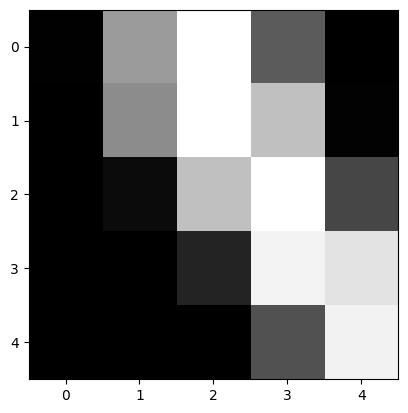

In [32]:
plt.imshow(image[0,10:15,10:15], cmap='gray')

Note that we need to pass just the 28x28 matrix to `plt.imshow`, without a channel dimension. We also pass a color map (`cmap=gray`) to indicate that we want to see a grayscale image.

Test two imags from the `MINST` dataset

image.shape: torch.Size([1, 28, 28])
Label: 5


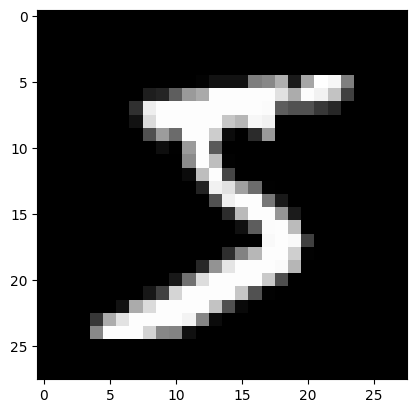

In [36]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 3


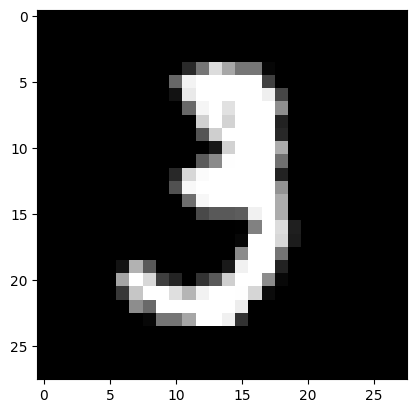

In [37]:
image, label = dataset[10]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

##**Traning and Validation Datasets**

A real-world machine learning model includes a **training set**, a **validation set** and a **test set**.

1. **Training set**: used to train the model, i.e., compute the **loss** and adjust the model's **weights** using **gradient descent**

2. **Validation set**: used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.

3. **Test set**: used to compare different models or approaches and report the model's final accuracy.

Recall that in the `MNIST` dataset, there are 60000 training images and 10000 test images (note that this 10000 test images are standardized and isolated from the 60000 images).

Therefore, we can manually split 60000 images into a training and a validation data set

+ choose the size of the **validation set** (e.g., randomly choosing 10000 images)
+ choose the size of the **training set** (e.g., randomly choosing 50000 images)

In [38]:
len(dataset)

60000

In [39]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create `PyTorch` data loaders for **training and validation**.

+ specify the batch size = $128$ for `DataLoader`
+ `num_workers=4`: Setting the argument `num_workers` as a positive integer will turn on **multi-process data loading** with the specified number of loader worker processes
+ setting `pin_memory=True`, which enables fast data transfer to **CUDA-enabled GPUs**
+ setting `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. Generalization is crucial for speeding up the training process.
+ note **no need** to set `shuffle=True` for the validation data loader because the validation data loader is used only for evaluating the model, there is no need to shuffle the images.



In [34]:
batch_size = 128

In [40]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`.

+ `.permute` is needed to move the channel color dimension to the last dimension for `matplotlib` to work.
+  `nrow` number of images displayed in each row of the grid (**actually the number of columns**).
+ `grid.shape torch.Size([3, 242, 482])` ($242$ is height and $482$ is width) shows that the channel dimension is on the first index, and we need to move it to the last index to be compatible with `imshow`.

- `images` is a 4D tensor with the shape [128, 1, 28, 28]. Let's break down how make_grid(images, nrow=16) transforms this input shape to [3, 242, 482]. The first dimension of images is 128, indicating that there are 128 images in the batch. Each image has a single channel, as indicated by the second dimension of size 1. Each image has a height of 28 pixels and a width of 28 pixels. **there's some padding or spacing between the images to make them visually distinguishable.** Since there are 128 images and each row of the grid contains 16 images, the number of rows in the grid will be 128 / 16 = 8. With 16 images per row, there will be 16 columns in the grid. Each image has a height of 28 pixels, and there are 8 rows in the grid. So, the total grid height will be 28 * 8 = 224 pixels. Each image has a width of 28 pixels, and there are 16 columns in the grid. So, the total grid width will be 28 * 16 = 448 pixels. In most cases, the output grid will have three color channels (RGB) for visualization purposes. This is likely why the output shape has a first dimension of size 3. **The padding or spacing** makes `[3, 242, 482]` not `[3, 224, 448]`.

+ $16 \times 8 = 128$ (a batch size)
+ `plt.figure(figsize=(16,8))` is just used to control the figure size. You can change `(16,8)` to a different pair to see how figure size changes
+ `nrow = 16` represents the number of columns in the output figure. Why $16$? While it can be any number, $16$ is chosen because $128$ is completely divisible by $16$. You can also set `nrow = 8` and the figure changes its shape of representation  


In [46]:
for images, _ in train_loader:
    print('image.shape:', images.shape)
    print('grid.shape', make_grid(images, nrow=16).shape)
    break

image.shape: torch.Size([128, 1, 28, 28])
grid.shape torch.Size([3, 242, 482])


images.shape: torch.Size([128, 1, 28, 28])


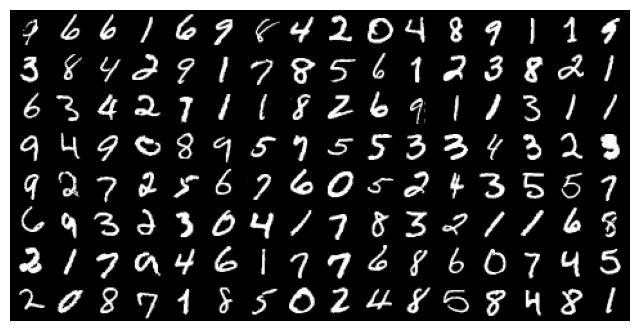

In [47]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

##**Model**

Now create our model using **logistic regression**

logistic regression is a **supervised learning algorithm** used for binary classification tasks. It models the probability that a given **input** belongs to one of **two classes**, e.g., postive or negative, 0 or 1, based on one or more independent variables. Logistic regression uses the logistic (sigmoid) function to map the output of a linear combination of features to a probability between **0 to 1**. The output of logistic regression is a **probability score**, and a threshold is applied to classify **inputs** into one of the two classes.

+ use a **logistic regression** that also contains weights and bias matrices. The output is obtained using simple matrix operations (`pred = x @ w.t() + b`).
+ just directly use `nn.Linear` to create the model
+ `nn.Linear` flattens each image **tensor** `1x28x28` into a **vector** of size 784 (28 x 28) before being passed into the model. (Note `nn.Linear` expects each training example to be a **vector**!)
+ The model output is a vector of size 10. Each of these 10 elements specifies the probability of a specific target label, ranging from 0 to 9.

In [61]:
import torch.nn as nn

input_size = 28 * 28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [62]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0090, -0.0204, -0.0262,  ...,  0.0243,  0.0345, -0.0276],
        [-0.0273,  0.0305, -0.0126,  ..., -0.0098,  0.0289, -0.0132],
        [-0.0130, -0.0288, -0.0084,  ..., -0.0229, -0.0173, -0.0081],
        ...,
        [ 0.0079,  0.0300,  0.0166,  ..., -0.0290, -0.0184, -0.0276],
        [-0.0253, -0.0225,  0.0056,  ..., -0.0231,  0.0334, -0.0288],
        [ 0.0140,  0.0331, -0.0221,  ...,  0.0235,  0.0033, -0.0225]],
       requires_grad=True)

The number of parameters for each image equals the number of inputs, which is 784, corresponding to the number of pixels. We have 784 input paramters for each target label, and in total 784 * 10 (label targets) = 7840 paramters. Set the batch size of 100 and pass the patch into our model.

In [63]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0164, -0.0302,  0.0073,  0.0279, -0.0228,  0.0210, -0.0013, -0.0062,
         0.0165, -0.0129], requires_grad=True)

In [51]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([7, 1, 2, 4, 1, 6, 1, 2, 8, 3, 0, 8, 6, 5, 8, 6, 4, 2, 5, 5, 9, 4, 0, 0,
        3, 6, 4, 7, 5, 6, 6, 3, 6, 1, 8, 3, 9, 9, 0, 7, 5, 7, 2, 4, 0, 2, 1, 8,
        5, 2, 5, 9, 7, 7, 0, 2, 8, 4, 8, 4, 3, 2, 6, 0, 7, 2, 0, 9, 4, 4, 5, 6,
        5, 5, 5, 8, 9, 2, 1, 2, 1, 3, 2, 2, 3, 0, 1, 8, 6, 0, 0, 9, 3, 4, 3, 4,
        4, 2, 1, 5, 3, 1, 7, 0, 0, 3, 4, 9, 1, 5, 2, 2, 1, 2, 3, 1, 9, 6, 5, 8,
        2, 1, 6, 0, 1, 7, 2, 0])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

In [52]:
images.shape

torch.Size([128, 1, 28, 28])

In [53]:
images.reshape(128,784).shape

torch.Size([128, 784])

note the error is due to the incorrect shape of the shape of each image, i.e., `1x28x28`. Instead of a 3D tensor, we need to flatten the tensor and convert it to be a vector of `784` elements. This corresponds to the `nn` module that requires vector input.  

`super().__init__()` is calling the constructor of the parent class from within the constructor of the child class, allowing the child class to initialize any attributes specific to itself while also running the initialization code in the parent class.

In object-oriented programming, a subclass (child class) can inherit methods and attributes from a superclass (parent class). When you define a method with the same name in both the superclass and the subclass, the method in the subclass overrides the one in the superclass. However, sometimes you want to extend the functionality of the method in the subclass while still utilizing the functionality of the method in the superclass. This is where `super().__init__()` comes into play.

`MnistModel` is inheriting from `nn.Module`, which is a class from PyTorch's `torch.nn` module. When you call `super().__init__()`, it invokes the `__init__` method of `nn.Module`, initializing the `MnistModel` instance as a PyTorch neural network module. This is crucial because `nn.Module` contains important functionalities and attributes required for defining and working with neural network models in PyTorch.

The `__init__` method of `MnistModel` then proceeds to define a linear layer (`nn.Linear`) as an attribute of the model. This linear layer is initialized with input_size and num_classes, which presumably are parameters defined elsewhere in your code.

`super().__init__()` ensures that the `MnistModel` instance is properly initialized as a PyTorch neural network module, and then additional attributes specific to the `MnistModel` class, such as the linear layer, are defined within its `__init__` method.

+ attributes are pieces of data associated with objects.
+ objects often refer to classes defined within a module. The module itself can also be thought of as a **special kind of object** in Python.
+ therefore you can define attributes within the class or out of the class within the module.
+ you can access and manipulate the corresponding attributes using **dot notation**: `obj_class.my_method()` or `obj_module.my_variable`

`nn.Linear` performs a linear transformation from an input feaure space of size 784 to an output feature space size 10, with each output representing the predicted score or probability assoicated with one of the targeted classes, i.e., 0-9. **The transformation is achieved through a combination of weights and biases, which are learned during the training process.**

```
output = input_features @ W + b

input features with dimensions: (128, 784)
W (weight matrix) with dimensions: (784, 10)

b (bias) with dimensions: (10,)
```

In [64]:
class MnistModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__() # inherit any attributes defined in the parent module, i.e., nn.Module
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
         print("Here in MnistModel original:", xb.shape)
         xb = xb.reshape(-1, 784) # -1 automatically calculates the number of rows
         print("Here in MnistModel after reshape:", xb.shape)
         out = self.linear(xb)
         return out
model = MnistModel(input_size, num_classes) # must instantiate the constructor method

In [65]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [56]:
print(model.linear.weight.shape, model.linear.bias.shape)

torch.Size([10, 784]) torch.Size([10])


In [57]:
for images, labels in train_loader: #train_loader contains 50000 images with specified batch size of 128
     print(images.shape)
     outputs = model(images)
     break

print('outputs.shape: ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
print('labels: \n', labels) # 128 true labels

torch.Size([128, 1, 28, 28])
Here in MnistModel original: torch.Size([128, 1, 28, 28])
Here in MnistModel after reshape: torch.Size([128, 784])
outputs.shape:  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0108,  0.2469,  0.1168, -0.0382,  0.2165, -0.2126, -0.0787,  0.0127,
         -0.0840,  0.2150],
        [-0.0216, -0.1564,  0.1903, -0.0638, -0.1106, -0.2955, -0.2655, -0.1619,
          0.1860,  0.1793]])
labels: 
 tensor([8, 9, 1, 8, 4, 6, 0, 3, 2, 0, 8, 0, 1, 8, 1, 0, 4, 0, 1, 4, 7, 0, 5, 2,
        9, 1, 3, 7, 7, 7, 7, 5, 0, 5, 9, 3, 8, 9, 1, 1, 1, 6, 8, 0, 1, 4, 4, 5,
        9, 0, 2, 8, 9, 5, 8, 1, 8, 7, 7, 7, 6, 2, 0, 3, 2, 3, 4, 4, 7, 4, 0, 6,
        3, 1, 5, 1, 9, 6, 2, 9, 0, 1, 5, 2, 9, 3, 7, 5, 4, 6, 5, 8, 9, 7, 7, 1,
        8, 8, 0, 7, 4, 3, 3, 6, 5, 9, 8, 7, 5, 1, 4, 1, 6, 9, 0, 2, 1, 2, 6, 0,
        5, 9, 1, 6, 1, 7, 5, 8])


For each 100 input images, 10 outputs can be obtained, and each output represents a probability lying between 0 to 1. These 10 output probabilites must add up to 1. The conversion of output elements into probabilities uses a `softmax` function. The available `softmax` function is defined in `torch.nn.functional`.

In [58]:
import torch.nn.functional as F

perform slicing starting from the first element and up to (but not including) the third element.

+ `:` indicates that we're performing slicing.
+ `2` indicates the index up to which we want to slice.
+ When using the slicing notation `[:2]` without specifying a dimension in a two-dimensional array in Python, it defaults to slicing along the rows.
+ The absence of a starting index before the `:` means that slicing starts from the beginning of the array.


In [59]:
print(outputs.shape)
print(outputs[:2])

torch.Size([128, 10])
tensor([[ 0.0108,  0.2469,  0.1168, -0.0382,  0.2165, -0.2126, -0.0787,  0.0127,
         -0.0840,  0.2150],
        [-0.0216, -0.1564,  0.1903, -0.0638, -0.1106, -0.2955, -0.2655, -0.1619,
          0.1860,  0.1793]], grad_fn=<SliceBackward0>)


In [60]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)
probs.shape
print("probs shape: ", probs.shape)
# Look at sample probabilities
print("Sample probabilities: \n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

probs shape:  torch.Size([128, 10])
Sample probabilities: 
 tensor([[0.0961, 0.1216, 0.1068, 0.0915, 0.1180, 0.0768, 0.0878, 0.0962, 0.0874,
         0.1178],
        [0.1015, 0.0887, 0.1255, 0.0973, 0.0929, 0.0772, 0.0796, 0.0882, 0.1249,
         0.1241]])
Sum:  0.9999998807907104


With all probabilites calculated for each row of the 128 rows (batch size), use `torch.max` to choose the largest element and the corresponding index.

In [67]:
max_probs, preds = torch.max(probs, dim=1)
print(probs.shape) #already converted
print(preds)
print(max_probs)

torch.Size([128, 10])
tensor([1, 2, 2, 2, 9, 1, 9, 9, 9, 0, 9, 0, 9, 9, 9, 9, 9, 5, 4, 4, 9, 8, 5, 8,
        9, 2, 9, 9, 2, 2, 9, 5, 8, 9, 1, 9, 5, 9, 9, 2, 9, 1, 9, 2, 2, 9, 9, 5,
        9, 2, 2, 9, 2, 2, 4, 9, 9, 9, 9, 2, 9, 6, 9, 0, 9, 2, 2, 9, 2, 1, 2, 9,
        5, 5, 2, 9, 9, 1, 4, 9, 8, 2, 9, 8, 1, 0, 9, 9, 9, 8, 9, 9, 2, 2, 2, 5,
        9, 5, 1, 2, 9, 2, 5, 8, 9, 9, 9, 9, 9, 7, 2, 2, 9, 4, 9, 4, 9, 6, 2, 9,
        9, 2, 9, 9, 9, 9, 9, 9])
tensor([0.1216, 0.1255, 0.1131, 0.1425, 0.1322, 0.1382, 0.1403, 0.1454, 0.1275,
        0.1339, 0.1379, 0.1572, 0.1262, 0.1602, 0.1226, 0.1542, 0.1289, 0.1534,
        0.1254, 0.1142, 0.1386, 0.1298, 0.1426, 0.1233, 0.1237, 0.1243, 0.1165,
        0.1308, 0.1359, 0.1190, 0.1324, 0.1246, 0.1186, 0.1213, 0.1241, 0.1284,
        0.1226, 0.1216, 0.1147, 0.1192, 0.1225, 0.1493, 0.1202, 0.1498, 0.1183,
        0.1142, 0.1243, 0.1399, 0.1180, 0.1155, 0.1225, 0.1368, 0.1150, 0.1353,
        0.1135, 0.1266, 0.1633, 0.1242, 0.1411, 0.1208, 0.1327, 0

actual labels

In [66]:
labels

tensor([8, 9, 1, 8, 4, 6, 0, 3, 2, 0, 8, 0, 1, 8, 1, 0, 4, 0, 1, 4, 7, 0, 5, 2,
        9, 1, 3, 7, 7, 7, 7, 5, 0, 5, 9, 3, 8, 9, 1, 1, 1, 6, 8, 0, 1, 4, 4, 5,
        9, 0, 2, 8, 9, 5, 8, 1, 8, 7, 7, 7, 6, 2, 0, 3, 2, 3, 4, 4, 7, 4, 0, 6,
        3, 1, 5, 1, 9, 6, 2, 9, 0, 1, 5, 2, 9, 3, 7, 5, 4, 6, 5, 8, 9, 7, 7, 1,
        8, 8, 0, 7, 4, 3, 3, 6, 5, 9, 8, 7, 5, 1, 4, 1, 6, 9, 0, 2, 1, 2, 6, 0,
        5, 9, 1, 6, 1, 7, 5, 8])

As can be seen clearly from above comparison, most of the predicted labels are different from the actual labels. That is due to randomly initialized weights and biases.

Let's improve the results by adjusting the weights using **gradient descent method**.

## **Evaluation Metric and Loss Function**

The accuracy of the predictions can be represented as the **percentage of labels that were predicted correctly**.

`torch.sum(preds == labels):` This computes the sum of all elements in the boolean tensor obtained from the comparison. Since True is equivalent to 1 and False is equivalent to 0, summing up these boolean values effectively counts the number of True values in the tensor.

In [87]:
torch.sum(preds == labels)
print(labels)
print(preds)


tensor([8, 9, 1, 8, 4, 6, 0, 3, 2, 0, 8, 0, 1, 8, 1, 0, 4, 0, 1, 4, 7, 0, 5, 2,
        9, 1, 3, 7, 7, 7, 7, 5, 0, 5, 9, 3, 8, 9, 1, 1, 1, 6, 8, 0, 1, 4, 4, 5,
        9, 0, 2, 8, 9, 5, 8, 1, 8, 7, 7, 7, 6, 2, 0, 3, 2, 3, 4, 4, 7, 4, 0, 6,
        3, 1, 5, 1, 9, 6, 2, 9, 0, 1, 5, 2, 9, 3, 7, 5, 4, 6, 5, 8, 9, 7, 7, 1,
        8, 8, 0, 7, 4, 3, 3, 6, 5, 9, 8, 7, 5, 1, 4, 1, 6, 9, 0, 2, 1, 2, 6, 0,
        5, 9, 1, 6, 1, 7, 5, 8])
tensor([1, 2, 2, 2, 9, 1, 9, 9, 9, 0, 9, 0, 9, 9, 9, 9, 9, 5, 4, 4, 9, 8, 5, 8,
        9, 2, 9, 9, 2, 2, 9, 5, 8, 9, 1, 9, 5, 9, 9, 2, 9, 1, 9, 2, 2, 9, 9, 5,
        9, 2, 2, 9, 2, 2, 4, 9, 9, 9, 9, 2, 9, 6, 9, 0, 9, 2, 2, 9, 2, 1, 2, 9,
        5, 5, 2, 9, 9, 1, 4, 9, 8, 2, 9, 8, 1, 0, 9, 9, 9, 8, 9, 9, 2, 2, 2, 5,
        9, 5, 1, 2, 9, 2, 5, 8, 9, 9, 9, 9, 9, 7, 2, 2, 9, 4, 9, 4, 9, 6, 2, 9,
        9, 2, 9, 9, 9, 9, 9, 9])


In [69]:
def accuracy(outputs, labels): # outputs consist of 128 images with 10 labels associated with each image.
    _, preds = torch.max(outputs, dim=1)
    #print(preds.shape) # 128 selected most-likely predictions
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))  #accuracy = number of correct/total number                          # outputs: probabilities # labels: 0 - 9 numbers

**Accuracy**, **probabilities**, and **cross-entropy**

1. accuracy is the average across all the output rows (128)

2. probabilities are for all elements across all the output rows (128)

3. average of the cross entropy across all the output rows to get the overall loss for a batch of data

In [100]:
accuracy(outputs, labels) #accuracy is the probability for one batch
nums, preds = torch.max(outputs, dim=1) # dim = 1 calculates the max value along the second dimension (labels), which corresponds to preds variable. nums variable refers to the corresponding values
print(outputs.shape)
print(nums.shape)
print(preds.shape)
print(nums)
print(preds)

torch.Size([128, 10])
torch.Size([128])
torch.Size([128])
tensor([0.2469, 0.1903, 0.1333, 0.3731, 0.3171, 0.3155, 0.3241, 0.3380, 0.2566,
        0.2032, 0.3175, 0.4389, 0.2348, 0.5213, 0.2050, 0.3703, 0.2649, 0.3735,
        0.2363, 0.1482, 0.3800, 0.1613, 0.3154, 0.2018, 0.2665, 0.2610, 0.1430,
        0.2752, 0.3065, 0.1722, 0.2136, 0.1872, 0.2078, 0.2022, 0.2591, 0.2202,
        0.1456, 0.2227, 0.1199, 0.1514, 0.1966, 0.3658, 0.0966, 0.3085, 0.1533,
        0.0953, 0.1421, 0.2600, 0.1437, 0.0026, 0.1876, 0.2988, 0.0804, 0.3061,
        0.0204, 0.2366, 0.5232, 0.2011, 0.3170, 0.1693, 0.3046, 0.2310, 0.0810,
        0.1694, 0.2392, 0.2127, 0.3119, 0.1903, 0.2202, 0.2602, 0.2656, 0.1719,
        0.2503, 0.0984, 0.3487, 0.1261, 0.2286, 0.2797, 0.2650, 0.3161, 0.1507,
        0.0766, 0.2209, 0.2271, 0.2487, 0.1955, 0.2890, 0.1960, 0.2303, 0.2873,
        0.2248, 0.1834, 0.3811, 0.1380, 0.1912, 0.0465, 0.1944, 0.1130, 0.4960,
        0.1683, 0.2556, 0.3815, 0.3317, 0.2422, 0.1810, 0.3819

In [74]:
probs.shape # probs includes the 128 probabilities for all images in one batch

torch.Size([128, 10])

Accuracy is useful for us to evaluate the model; hence it is used as an **evaluation metric**. However, it cannot be used as a loss function for two reasons:

1. It's not differentiable, i.e., `torch.max` and `==`.

2. It doesn't include true probabilities and therefore it doesn't provide sufficient feedback for incremental improvements.

A commonly used **loss function** for classification problems is the **cross-entropy**.

+ cross-entropy is a continuous and differentiable function. These two factors make cross-entropy a better choice for the **loss function**. **The lower the loss, the better the model.**

Basically, it calculates the `log` of picked probability. If the probability is close to 1, it gives a very small negative value. On the other hand, the probability is close to 0, it gives a very large negtive value, which means poor predictions. We also need to multiply the result by -1 to kill the negative sign.

**cross-entropy** has been built into `torch.nn.functional`. It also performs `softmax` internally, so we can directly pass model's outputs without converting them into probabilities.

In [101]:
loss_fn = F.cross_entropy

In [102]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3225, grad_fn=<NllLossBackward0>)


##**Traning the model**

Therefore, we need the following items to train the model

1. `dataLoader` to specify the train and validation datasets

2. model

3. loss function

4. optimizer

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

**The universal** parts within a function called `fit`, which will be used to train the model. Besides, the **problem specific** parts will be implemented by adding new methods to the `nn.Module` class.

In [77]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

The `fit` function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging and visualization.

In [78]:
l1 = [1, 2, 3, 4, 5]

In [79]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [80]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finally, let's redefine the `MnistModel` class to include additional methods `training_step`, `validation_step`, `validation_epoch_end`, and `epoch_end` used by `fit` and evaluate.

In [83]:
class MnistModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        #print(out.shape)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return{'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


model = MnistModel(784, 10)

In [84]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3406126499176025, 'val_acc': 0.07265625149011612}

The initial accuracy is around 7%. This result is expected from a randomly initialized model. Let's train another 5 epochs to see how accuracy might be improved.

In [85]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch[0], val_loss: 1.9707, val_acc: 0.5811
Epoch[1], val_loss: 1.6964, val_acc: 0.7080
Epoch[2], val_loss: 1.4918, val_acc: 0.7483
Epoch[3], val_loss: 1.3375, val_acc: 0.7719
Epoch[4], val_loss: 1.2190, val_acc: 0.7867


In [103]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch[0], val_loss: 1.1260, val_acc: 0.7969
Epoch[1], val_loss: 1.0513, val_acc: 0.8052
Epoch[2], val_loss: 0.9902, val_acc: 0.8124
Epoch[3], val_loss: 0.9394, val_acc: 0.8179
Epoch[4], val_loss: 0.8963, val_acc: 0.8226


In [104]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch[0], val_loss: 0.8594, val_acc: 0.8274
Epoch[1], val_loss: 0.8275, val_acc: 0.8311
Epoch[2], val_loss: 0.7995, val_acc: 0.8351
Epoch[3], val_loss: 0.7748, val_acc: 0.8384
Epoch[4], val_loss: 0.7528, val_acc: 0.8410


In [105]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch[0], val_loss: 0.7330, val_acc: 0.8446
Epoch[1], val_loss: 0.7151, val_acc: 0.8461
Epoch[2], val_loss: 0.6989, val_acc: 0.8477
Epoch[3], val_loss: 0.6841, val_acc: 0.8499
Epoch[4], val_loss: 0.6706, val_acc: 0.8518


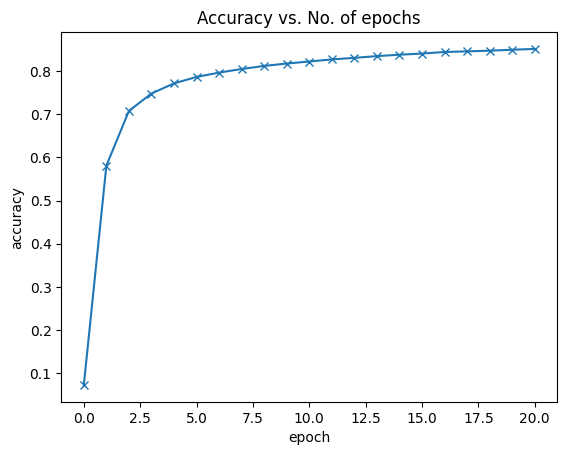

In [106]:
#result0 is a dict and [result0] creates a new list that can be concatenated to history list variables
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

**Observations**

+ accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch.

+ the model seems not to exceed the accuracy threshold of 90% even after training for a very long time.

+ lower the learning rate (hyperparamter) to expect any improvements

+ it is likely that the model is not **good enough**. As **linear relationship** was assumed through `nn.Linear`, while the relation between pixels and digit it represents might not floow a linear relationship. **More sophisticated models** that can capture non-linear relationships between ** image pixels and labels** should be adopted to improve accuracy.

##**Testing with individual images**

In [107]:
test_dataset = MNIST(root='data/',
                     train = False,
                     transform=ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


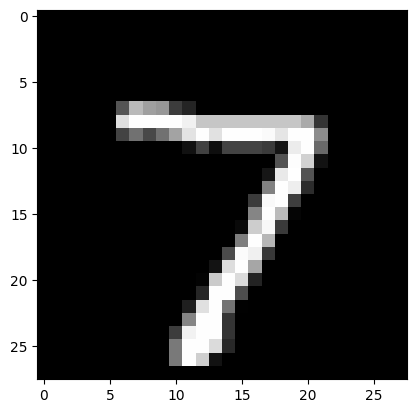

In [108]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [109]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb) #will call forward method. Note forward method is called by default since it is a special method in PyTorch
    _, preds = torch.max(yb, dim=1)
    print(preds.item())
    return preds[0].item()

7
Label: 7 , Predicted: 7


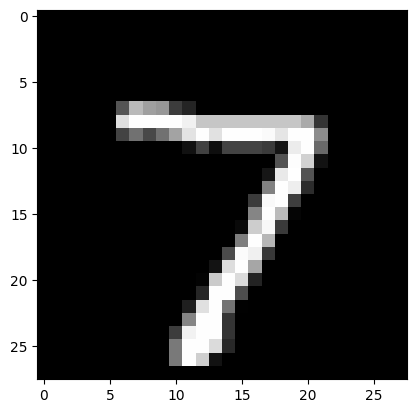

In [110]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model)) # train

0
Label: 0 , Predicted: 0


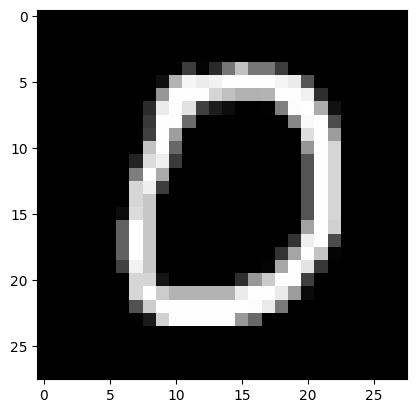

In [111]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap = 'gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

3
Label: 9 , Predicted: 3


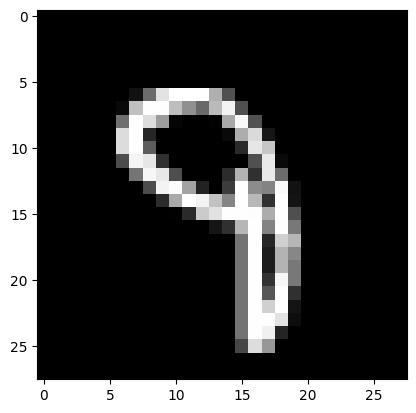

In [112]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

8
Label: 2 , Predicted: 8


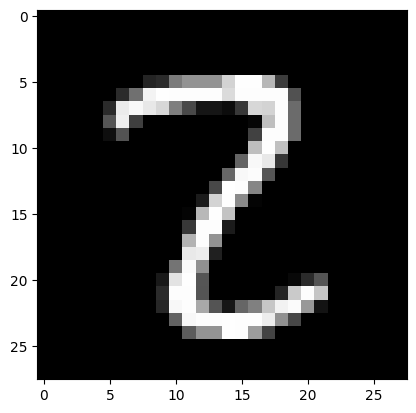

In [113]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [114]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.642600417137146, 'val_acc': 0.85888671875}

##**Saving and loading the model**

In order to reuse the model to save the trained weights and bias matrices to avoid retraining from scratch.

+ `model` is the instance you created. It is not a special word. You can change the name of the instance from `model` to `my_model` if you like.

+ the current state of the `model`'s parameters is saved to the specified file `mnist-logistic.pth`.

In [116]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [117]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0214,  0.0280, -0.0319,  ..., -0.0069, -0.0246, -0.0053],
                      [-0.0326, -0.0066, -0.0080,  ...,  0.0268, -0.0157, -0.0008],
                      [-0.0338, -0.0174,  0.0115,  ...,  0.0353,  0.0339,  0.0110],
                      ...,
                      [-0.0336, -0.0330, -0.0056,  ...,  0.0177,  0.0294,  0.0144],
                      [ 0.0342, -0.0347, -0.0124,  ...,  0.0261,  0.0283,  0.0132],
                      [ 0.0018, -0.0120, -0.0109,  ...,  0.0175,  0.0170,  0.0250]])),
             ('linear.bias',
              tensor([-0.0228,  0.1080,  0.0065,  0.0045,  0.0333,  0.0414,  0.0056,  0.0674,
                      -0.1214, -0.0173]))])

To load the model weights, you need to instantiate a **new object**, e.g., `model2` and use the `.load_state_dict` method.

In [119]:
model2 = MnistModel(784,10)

`model2.state_dict()` prints out the the current randomized weights and biases.

In [120]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0282, -0.0134, -0.0131,  ..., -0.0083, -0.0046, -0.0354],
                      [ 0.0307, -0.0156, -0.0272,  ...,  0.0113, -0.0209,  0.0077],
                      [ 0.0310,  0.0285,  0.0216,  ..., -0.0205, -0.0072,  0.0214],
                      ...,
                      [-0.0351, -0.0119, -0.0267,  ...,  0.0051, -0.0234, -0.0336],
                      [ 0.0255, -0.0149, -0.0095,  ...,  0.0088, -0.0189, -0.0256],
                      [-0.0086,  0.0301,  0.0112,  ..., -0.0354, -0.0082,  0.0093]])),
             ('linear.bias',
              tensor([-0.0084,  0.0039, -0.0117, -0.0071, -0.0201,  0.0277, -0.0039,  0.0059,
                      -0.0034, -0.0014]))])

we see the loss is large and the accuracy is low 5%.

In [122]:
evaluate(model2, test_loader)

{'val_loss': 2.3284454345703125, 'val_acc': 0.05839843675494194}

Now load the saved weights and biases that have been trained using `load_state_dict` method.

In [124]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0214,  0.0280, -0.0319,  ..., -0.0069, -0.0246, -0.0053],
                      [-0.0326, -0.0066, -0.0080,  ...,  0.0268, -0.0157, -0.0008],
                      [-0.0338, -0.0174,  0.0115,  ...,  0.0353,  0.0339,  0.0110],
                      ...,
                      [-0.0336, -0.0330, -0.0056,  ...,  0.0177,  0.0294,  0.0144],
                      [ 0.0342, -0.0347, -0.0124,  ...,  0.0261,  0.0283,  0.0132],
                      [ 0.0018, -0.0120, -0.0109,  ...,  0.0175,  0.0170,  0.0250]])),
             ('linear.bias',
              tensor([-0.0228,  0.1080,  0.0065,  0.0045,  0.0333,  0.0414,  0.0056,  0.0674,
                      -0.1214, -0.0173]))])

Check if this model has the same loss and accuracy on the test set as before

In [125]:
teset_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.642600417137146, 'val_acc': 0.85888671875}

#**Appendix**

## **Hidden Layers, Activation Functions and Non-Linearity**

We'll create a neural network with two layers: a **hidden layer** and an **output layer**. Additionally, we'll use an **activation function** between the two layers

+ how **hidden layers** and **activation functions** can help capture non-linear relationships between inputs and outputs

+ First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object

1. `images` contains a set of batches

2. Recall linear regression takes only a one-dimensional vector of each batch, therefore we have to convert $28 \times 28$ into $784$ (2D to 1D)

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])


In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object as our **hidden layer**.

+ We'll set the size of the output from the hidden layer to $32$. (This number can be increased or decreased to change the **learning capacity** of the model.)

+ recall the **linear logistic regression model** `model = nn.Linear(input_size, num_classes)` takes `input_size` ($784$ one image contains $28 \times 28$ pixels) and `num_classes` ($10$ outputs)

+ here we use the same `input_size` ($784$) but **set the intermediate hidden layer** be $32$ for the output

In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

print('input_size: ',input_size)

input_size:  784


**input_size:** $784$ \\
**hidden_size:** $32$ (a different value can be used)

**Step one:** created layer one

In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

+ `inputs` ($128 \times 784$) is converted to the dimension (reshape(-1, 784)) that is compatible with the `nn.Linear()` model

+ `layer1` is a linear regression model, which contains **weights** (layer1.weights) and **bias** (layer1.biase)

In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The **inputs matrix** ($128 \times 784$) is transformed into **intermediate output matrix** ($128 \times 32$) by performing a **direct matrix multiplication**:

+  `inputs` matrix with the **transposed weights matrix** of `layer1` and adding the bias.

+ recall **weights** dimensions: number of training examples ($128$) times number of outputs ($32$), and **bias** dimension is number of outputs ($32$)

We can verify this using `torch.allclose`.

In [ ]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [ ]:
print('weights dimensions: ', layer1.weight.shape)
print('bias dimensions: ', layer1.bias.shape)
print('inputs dimensions: ', inputs.shape)

weights dimensions:  torch.Size([32, 784])
bias dimensions:  torch.Size([32])
inputs dimensions:  torch.Size([128, 784])


`layer1` and direct matrix operation give the same results, and we get "True"

In [ ]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

## linear relationship

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements ($728$ pixels) from `inputs`.

Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

## non-linear relationship (activation function removing negative values)
Next, we'll use the **Rectified Linear Unit (ReLU) function** as the **activation function** for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. **ReLU is a non-linear function**, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [ ]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values were replaced with 0.

+ note that `F.relu` does not change the shape

**Step two:** taking the outputs from `layer1` at **step one** to create a **nonlinear layer output** `relu_outputs`

In [ ]:
relu_outputs = F.relu(layer1_outputs)
print('relu_outputs.shape', relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

relu_outputs.shape torch.Size([128, 32])
min(layer1_outputs): -0.74245285987854
min(relu_outputs): 0.0


With the **activation function** `ReLU`, the relationship between`relu_outputs` and `inputs` is no longer linear.

+ for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

+ Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length $10$, which is the desired output of our model (since there are $10$ target labels).

_Quesiont: why is this Rectified activation function good?_ \\
Ans: it removes the negtive values that are not physically realistic

In [ ]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

**Step three:** taking the nonlinear output results (`relu_outputs`) from **step two** to create a linear relationship (`layer2_outputs`)

In [ ]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


## Gradient descent (`cross_entry`)
As expected, `layer2_outputs` contains a batch of vectors of size $10$. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using **gradient descent.**

In [ ]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3272, grad_fn=<NllLossBackward0>)

Thus, our model

1. transforms `inputs` into `layer2_outputs` by applying a **linear transformation** (using `layer1`),
2. followed by a **non-linear activation** (using `F.relu`),
3. followed by another **linear transformation** (using `layer2`).

Let's verify this by re-computing the output using basic matrix operations.

In [ ]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [ ]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

1. Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`.
2. we train the model and adjust **ONLY** the weights of `layer1` and `layer2`,
3. we can now capture non-linear relationships between the images and their labels. In other words, **introducing non-linearity** makes the model more powerful and versatile.
4. since `hidden_size` does **NOT** depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model.
5. We can also introduce **new hidden layers** and apply the same non-linear activation after each hidden layer (**multi-layered relationships**).

The model we just created is called **a neural network**. A **deep neural network** is simply **a neural network with one or more hidden layers**. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices (**weights and biases**), applying **non-linear activations**, and adjusting **weights repeatedly using gradient descent** can yield such **astounding results**.

Deep learning models often contain **millions of parameters**, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation **between the two linear layers**, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

_Question:_ must it be a linear relationship between the first input layer and the final output layer?

Activation function add non-linearity and changes the linear relationship.

In [ ]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

recall **input_size:** $784$, and **output_size:** $10$

In [ ]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

inputs passed to `layer1` and `layer2` is same as inputs passed to the **combined layer**

In [ ]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [ ]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with **one hidden layer**. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of **inputs** (**pixel intensities**) into **outputs** (**class probabilities**), we'll use two `nn.Linear` objects. Each of these is called a **layer** in the network.

* The **first layer** (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear **activation function** to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the **activation function**, which is also of size `batch_size x hidden_size`, is passed into the **second layer** (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`.
* We can use this output to compute the loss and adjust **weights using gradient descent**.

Usually, **input and target output** are not called layers.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

+ `xb` is the original two dimensional images data that need to be flatten
+ `in_size` is $784$



In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

+ outputs are the **probabilities of each label**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We'll create a model that contains a hidden layer with 32 activations.

In [ ]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [ ]:
model = MnistModel(input_size, hidden_size, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

+ layer one takes $784$ inputs and generates $32$ outputs
+ layer two takes $32$ inputs and generates $10$ outputs

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of $128$ images from our dataset and pass them into our model.

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.309051275253296
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1040,  0.1556, -0.1310, -0.0144,  0.2014, -0.1363, -0.0679, -0.2559,
         -0.0883,  0.0662],
        [-0.2637,  0.1694, -0.1949, -0.0729,  0.1659, -0.0539, -0.0929, -0.2201,
         -0.1587, -0.1008]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use **GPUs** to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

+ CUDA is the language used to communicate with the GPU

In [ ]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't.

+ **Always** check if a GPU is avaiable by doing the following
+ `torch.device('cuda')` returns a pointer to the GPU
+ `torch.device('cpu')` returns a pointer to the CPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function (`to_device`) that can move data and model to a chosen device, `isinstance()` ensures only a **tensor** or a **model** is moved to the interested device
+ both `tensor` or `model` in pytorch have `to` method
+ data by default are sitting on **CPU** and we need to move them to **GPU**
+ CPU memory is usually much larger than the GPU memory
+ we move the data to the device we just checked above, e.g., GPU or CPU, the data can be either a **tensor** or a **model**
+ we can move `to_device` to move multiple tensors **at once**


In [ ]:
#move a model or a tensor to GPU
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

`.device` method to check where data are stored

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    print(images.device)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we **don't need** to extend an existing class to create a PyTorch data loader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

* `dl` dataloader
* `self.dl` and `self.device` store the arguments in the current object
* `__iter__()` function returns an **iterator object** that goes through the each element of the given object, otherwise you cannot use `for` to loop through all batches, so `__iter__()` is a **MUST**  
+ `__len__()` returns the number of batches, it is **not a must**  
* we should use `yield` when we want to iterate over a sequence, but don’t want to store the entire sequence in memory. `yield` is used in **Python generators**




In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        print('Minghan one')
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        print('you are in __iter()__')
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        print('You are in __len__(self)')
        """Number of batches"""
        return len(self.dl)

`num` is the output (yield) of the method `nextSquare()`

In [ ]:
def nextSquare():
    i = 1

    # An Infinite loop to generate squares
    while True:
        yield i*i
        i += 1  # Next execution resumes
        # from this point


# Driver code to test above generator
# function
for num in nextSquare():
    if num > 100:
        break
    print(num)

1
4
9
16
25
36
49
64
81
100


The `yield` keyword in Python is used to create a generator function that can be used within a `for` loop, as illustrated below.

In [ ]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


We can now wrap our data loaders using `DeviceDataLoader`.

+ `train_loader` and `val_loader` objects are iterator objects that contain two attributes `dl` and `device`

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Minghan one
Minghan one


In [ ]:
train_loader.device
train_loader.__len__()
train_loader.__iter__()

You are in __len__(self)


<generator object DeviceDataLoader.__iter__ at 0x7fe4a665f040>

Tensors moved to the GPU have a `device` property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

+ `for` can be used to loop through all batches due to `__iter__()` defined in the `DeviceDataLoader()`

In [ ]:
for xb, yb in val_loader:
    print('yb.device:', yb.device)
    print('yb:', yb)
    break

you are in __iter()__
yb.device: cuda:0
yb: tensor([0, 1, 1, 4, 3, 3, 1, 8, 0, 7, 0, 9, 8, 8, 3, 6, 4, 7, 7, 5, 2, 4, 4, 0,
        6, 9, 3, 5, 5, 0, 2, 7, 3, 7, 8, 7, 9, 3, 7, 4, 0, 2, 4, 5, 1, 4, 1, 1,
        3, 0, 5, 7, 2, 0, 1, 3, 9, 1, 7, 7, 5, 6, 6, 3, 4, 2, 2, 2, 4, 3, 2, 2,
        3, 0, 5, 1, 9, 1, 8, 4, 3, 8, 9, 3, 6, 6, 0, 9, 3, 7, 0, 8, 3, 9, 5, 5,
        8, 6, 6, 2, 9, 0, 5, 9, 1, 0, 0, 8, 4, 9, 6, 5, 0, 2, 9, 9, 7, 4, 6, 0,
        5, 1, 2, 9, 5, 4, 8, 6, 2, 7, 1, 5, 5, 6, 1, 9, 4, 4, 7, 5, 9, 2, 9, 2,
        5, 4, 4, 8, 1, 9, 9, 6, 1, 9, 8, 1, 8, 3, 3, 1, 9, 5, 3, 5, 3, 3, 0, 7,
        2, 8, 6, 7, 7, 5, 7, 2, 9, 6, 2, 0, 2, 2, 1, 9, 9, 6, 3, 5, 3, 0, 6, 3,
        6, 3, 4, 8, 1, 6, 9, 6, 7, 2, 0, 2, 8, 8, 5, 8, 3, 6, 4, 1, 5, 2, 8, 1,
        2, 2, 8, 1, 4, 2, 8, 8, 9, 9, 6, 4, 8, 7, 8, 2, 4, 2, 0, 9, 0, 2, 6, 3,
        5, 7, 2, 7, 9, 9, 6, 7, 5, 8, 8, 3, 5, 9, 9, 7], device='cuda:0')


In [ ]:
print('xb.shape',xb.shape)
print('yb.shape',yb.shape)

xb.shape torch.Size([256, 1, 28, 28])
yb.shape torch.Size([256])


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using **gradient descent and evaluate its performance on the validation set**. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

+ it takes `epochs` (hyperparameter given by the user)
+ learning rate (`lr`)
+ model (`model`)
+ training data (`train_loader`)
+ validation data (`val_loader`)
+ gradient descent (`torch.optim.SGD`)
+ `histroy` is the log to print

How the model works to train each batch of the training loader

1. `for batch in train_loader:` gets a batch of data from the training data loader
2. `training_step` should be specific (defined differently for different problems)
3. `loss.bacckward()` calculates the **gradient wrt weights and biases** for each layer
4. `optimizer.step()` performs the **gradient descent** to update the weights
5. `optimizer.zero_grad()` reset all gradients back to zero


recall the `fit` function from the **logistic linear regression model**, the same form applies to the nonlinear model.

+ the `fit` function is general

```
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history
```

how `evaluate` function works

+ gets batches from the **validation dataloader** and for each batch of data calls `model.validation_step(batch)`, it gives **accuracy** and **loss** for each batch of **validation data**

+ combine all the validation sets by calling `model.validation_epoch_end(outputs)` to give the **overall accuracy** and **overall loss** on the validation data set

+ then we get `result` and `epoch_end(epoch, result)` will present **validation loss and validation accuracy**

+ finally we append the `result` to `history`, which tracks how the accuracy and loss changes with epochs over time; we can know from the history 1) increase learning rate if too slow 2) decrease learning rate if bouncing around, etc

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the **model's parameters (weights and biases)** are on the same device (CPU or GPU).

We can reuse the `to_device` function to move the model's parameters to the right device.

+ we have already moved the training data loader to the right device

+ now we need to move the model over to the same device

Again model parameters are

1. input_size ($28 \times 28$)
2. hidden_size ($32$)
3. out_size ($10$)

In [ ]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the **validation set** with the **initial set of weights and biases**.

* using GPU is pretty fast, e.g., less than a second

* The initial accuracy is around 10%, as one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).



In [ ]:
history = [evaluate(model, val_loader)]
history

you are in __iter()__


[{'val_loss': 2.3034827709198, 'val_acc': 0.08193359524011612}]

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of $0.5$.

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

you are in __iter()__
you are in __iter()__
Epoch [0], val_loss: 0.2301, val_acc: 0.9350
you are in __iter()__
you are in __iter()__
Epoch [1], val_loss: 0.2092, val_acc: 0.9367
you are in __iter()__
you are in __iter()__
Epoch [2], val_loss: 0.1908, val_acc: 0.9427
you are in __iter()__
you are in __iter()__
Epoch [3], val_loss: 0.1534, val_acc: 0.9530
you are in __iter()__
you are in __iter()__
Epoch [4], val_loss: 0.1500, val_acc: 0.9548


96% is pretty good! Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

Now let decrease the learning rate to increase the accuracy but compensate time cost:

+ you see the accuracy increases to $96\%$ at the first Epoch!

In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

you are in __iter()__
you are in __iter()__
Epoch [0], val_loss: 0.1205, val_acc: 0.9633
you are in __iter()__
you are in __iter()__
Epoch [1], val_loss: 0.1203, val_acc: 0.9630
you are in __iter()__
you are in __iter()__
Epoch [2], val_loss: 0.1216, val_acc: 0.9644
you are in __iter()__
you are in __iter()__
Epoch [3], val_loss: 0.1192, val_acc: 0.9647
you are in __iter()__
you are in __iter()__
Epoch [4], val_loss: 0.1176, val_acc: 0.9645


We can now plot the losses & accuracies to study how the model improves over time.

+ losses starts at a large value and quickly decreases and flattens out

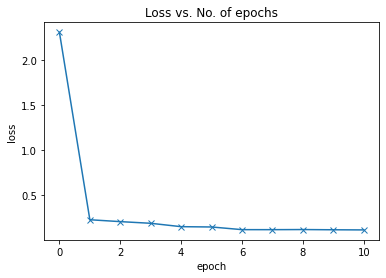

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

similarly accuracy starts at a very low value and increases quickly and flattens out

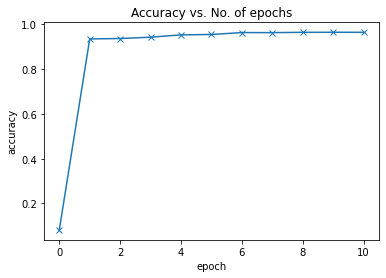

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Our current model outperforms the logistic regression model (which could only achieve around 86% accuracy) by a considerable margin!

1. It quickly reaches an accuracy of 97% but doesn't improve much beyond this.
2. To improve accuracy further, we need to make the model **more powerful by increasing the hidden layer's size** or adding **more hidden layers** with activations.

## Testing with individual images

So far we have trained our model using the **training dataset** and validated our model using the **validation dataset** with the **overall accuracy** being tracked. Now it is time to look at model's results on some sample images from the **test dataset**.

1. train the model using **training dataset**
2. validate the model using **validation dataset**
3. test the model using the **test dataset**

Let's test out our model with some images from the **predefined test dataset** of $10000$ images. We begin by recreating the **test dataset** with the `ToTensor` transform.

+ again `ToTensor` will convert the original data to pytorch tensor

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor. Interestingly, let's compare the `predict_image` for the **linear logistic regression model** to the one for the current **nonlinear logistic regression model**.

```
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()
```

1. both use `unsqueeze(0)` to add another dimension to make this ONE test image in the shape similar to the data shape obtained from the entire dataset, i.e., `[1, 1, 28, 28]`. I also tested the one without `unsqueeze(0)` and nothing has changed. I guess it will not fail every time but for some special cases it will not work. Still need to test out what the cases are.

2. the **difference** is that we need to move the image data to the GPU device via `to_device()`. Otherwise, you will get errors.

3. it should be noted that the CPU does not have the GPU ram and vice versa



In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    print(xb.device)
    #xb = to_device(img, device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Let's try it out with a few images.

cuda:0
Label: 7 , Predicted: 7


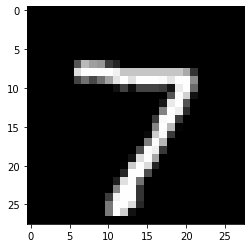

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

cuda:0
Label: 2 , Predicted: 2


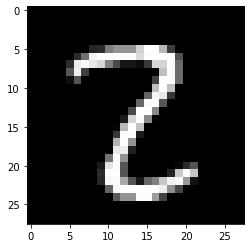

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

cuda:0
Label: 9 , Predicted: 9


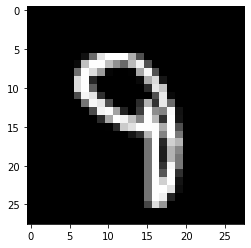

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying **where our model performs poorly** can help us improve the model,

1. by collecting **more training data**
2. increasing/decreasing the **complexity of the model**
3. and changing the **hypeparameters**

As a **final step**, let's also look at the

1. **overall loss** and
2. **overall accuracy**

of the model on the **test set**.

We expect the loss using the **test dataset** to be similar to the accuracy/loss on the **validation set**. If not, we might need a **better validation set** that has similar data and distribution as the test set (which often comes from real world data).

**Note that we want to improve the validation set NOT the test set.**

+ always check your result before you change anything!, e.g., blindly increase or decrease the learning rate, increase the number of epochs, etc. Sometimes, it might be due to

1. bad data
2. incorrectly labeled data
3. too less data


we only have $96\%$ accuracy, and $4\%$ of $50000$ is still a large number, i.e., $2000$ images.

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

Minghan one
you are in __iter()__


{'val_loss': 0.10274878889322281, 'val_acc': 0.9677734375}